# Binary classifier with Scikit-learn and Tensorflow

Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib #To save and load models

In [ ]:
!cp drive/MyDrive/paper2_data/mltools.py .
import mltools

In [33]:
#Scikit learn packages
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# 2-year survival model (binary classifier)

## Import data

This exercise uses dataset of lung cancer patients and **the aim is to predict patient survival status at the end of 2 years after diagnosis.**

The outcome is a binary variable indicating living or deceased status at the end of 2 years.

The dataset contains information about patient's age, sex, smoking status (current, former, never), cancer stage (Stage I, II, III or IV) and tumor histology (LUAD - lung adenocarcinoma; LUSC - lung squamous cell carcinoma; other).

In addition to the clinical data, there RNA-seq gene expression values for 4,544 genes. The gene expression data is normalised using standard bioinformatic tools.

In [ ]:
#All data
data = pd.read_csv('drive/MyDrive/dsf_summer_school/lung_cancer_dataset.csv')
print(data.shape)
data.head()

(748, 4550)


,Deceased_at_2yrs,Age,Sex,Smoking,Histology,Stage_simple,TSPAN6,C1orf112,CFH,LAS1L,SEMA3F,CFTR,ANKIB1,KRIT1,LAP3,WNT16,HECW1,DBNDD1,RBM5,PLXND1,CD38,KDM1A,RBM6,RECQL,ARHGAP33,ABCB5,DVL2,HOXA11,DHX33,LIG3,SPPL2B,COPZ2,MSL3,CREBBP,GCFC2,WDR54,CROT,ABCB4,KMT2E,IBTK,...,CEBPA,PGAM5,MARS2,FMN1,FER1L5,KIAA1210,CDK3,ZNF345,SHANK3,PRB1,PTX4,HOXA10,TMEM200B,PRKDC,ETV3L,ZNF260,LYN,PINX1,SIGLEC12,MAGEL2,RTL1,MEX3A,LSM14A,TAS2R38,MGAM,FNTB,ZNF878,CUX1,CHURC1,RTEL1,MC1R,BLID,ZNF234,MYH4,SPIB,ZIM2,CTAGE6,MILR1,KMT2B,SNURF
0,False,67.0,Male,former,LUAD,Stage 1,0.000130,0.000039,0.000255,0.000157,0.000132,0.000086,0.000292,0.000073,0.000493,3.000000e-07,0.000003,0.000072,0.000504,0.000732,0.000025,0.000274,0.000572,0.000075,0.000042,1.440000e-06,0.000087,0.000000e+00,0.000087,0.000192,0.000131,0.000015,0.000133,0.001382,0.000045,0.000045,0.000041,0.000011,0.000654,0.000367,...,0.000091,0.000102,0.000049,0.000282,6.000000e-07,4.800000e-07,0.000007,0.000031,0.000158,0.000000e+00,4.860000e-06,9.840000e-06,0.000004,0.000947,1.200000e-07,0.000138,0.000317,0.000018,0.000002,2.400000e-07,6.000000e-08,0.000306,0.000466,0.000000e+00,0.000036,0.000069,7.380000e-06,0.001222,0.000162,0.000034,0.000012,0.000000e+00,0.000077,6.000000e-08,0.000027,6.000000e-08,0.000000e+00,0.000012,0.000467,0.000006
1,True,79.0,Female,former,LUAD,Stage 3,0.000163,0.000058,0.000422,0.000186,0.000071,0.000010,0.000510,0.000065,0.000622,2.530000e-06,0.000023,0.000092,0.000268,0.000790,0.000035,0.000287,0.000273,0.000348,0.000052,4.320000e-07,0.000140,6.170000e-07,0.000149,0.000233,0.000049,0.000035,0.000125,0.000575,0.000044,0.000108,0.000041,0.000011,0.000472,0.000230,...,0.000016,0.000124,0.000056,0.000179,1.230000e-06,0.000000e+00,0.000001,0.000017,0.000110,0.000000e+00,6.170000e-08,1.250000e-05,0.000022,0.000928,2.470000e-07,0.000126,0.000326,0.000033,0.000003,1.110000e-06,6.240000e-06,0.000035,0.000526,0.000000e+00,0.000004,0.000039,8.030000e-07,0.000726,0.000135,0.000051,0.000015,6.790000e-07,0.000075,6.170000e-08,0.000002,0.000000e+00,0.000000e+00,0.000007,0.000450,0.000006
2,False,70.0,Male,former,LUAD,Stage 1,0.000336,0.000073,0.000317,0.000198,0.000293,0.000046,0.000296,0.000083,0.000653,4.020000e-05,0.000017,0.000084,0.000295,0.001987,0.000029,0.000293,0.000228,0.000114,0.000040,1.460000e-06,0.000165,8.780000e-07,0.000085,0.000220,0.000103,0.000011,0.000134,0.000706,0.000073,0.000034,0.000049,0.000033,0.000468,0.000268,...,0.000253,0.000191,0.000086,0.000114,2.490000e-06,1.170000e-06,0.000003,0.000030,0.000065,5.120000e-07,0.000000e+00,1.270000e-05,0.000003,0.002486,2.190000e-07,0.000116,0.000491,0.000018,0.000005,7.320000e-08,0.000000e+00,0.000083,0.000631,2.190000e-07,0.000004,0.000051,8.050000e-07,0.000654,0.000149,0.000030,0.000011,0.000000e+00,0.000064,7.320000e-08,0.000015,0.000000e+00,7.320000e-08,0.000017,0.000404,0.000008
3,False,58.0,Female,former,LUAD,Stage 1,0.000146,0.000081,0.000186,0.000173,0.000079,0.000082,0.000258,0.000067,0.000270,3.840000e-07,0.000006,0.000103,0.000401,0.001049,0.000019,0.000391,0.000412,0.000071,0.000058,1.020000e-06,0.000164,2.560000e-07,0.000093,0.000162,0.000152,0.000028,0.000085,0.000937,0.000055,0.000119,0.000021,0.000027,0.000461,0.000229,...,0.000034,0.000207,0.000049,0.000053,1.660000e-06,1.150000e-06,0.000002,0.000015,0.000096,0.000000e+00,1.280000e-07,6.400000e-07,0.000010,0.002119,0.000000e+00,0.000088,0.000548,0.000037,0.000005,1.150000e-06,0.000000e+00,0.000106,0.000478,0.000000e+00,0.000003,0.000108,4.610000e-06,0.000592,0.000187,0.000037,0.000010,0.000000e+00,0.000040,1.280000e-07,0.000002,0.000000e+00,1.280000e-07,0.000010,0.000427,0.000004
4,True,76.0,Male,former,LUAD,Stage 2,0.000074,0.000033,0.001240,0.000090,0.000033,0.000002,0.000450,0.000119,0.000517,6.450000e-07,0.000005,0.000065,0.000267,0.000359,0.000013,0.000327,0.000218,0.000245,0.000010,3.580000e-06,0.000162,6.110000e-06,0.000068,0.000149,0.000084,0.000007,0.000074,0.000619,0.000084,0.000044,0.000041,0.000022,0.000177,0.000220,...,0.000004,0.000221,0.

## Data preparation - Dummy variables, scalling and imputation

In [ ]:
#---Get the outcome y
y = data['Deceased_at_2yrs']
y

0      False
1       True
2      False
3      False
4       True
       ...  
743    False
744    False
745    False
746    False
747    False
Name: Deceased_at_2yrs, Length: 748, dtype: bool

In [ ]:
#---Get the covariate matrix X (one-hot encoded)
#Dummy variables/One-hot encoding
#X = data.drop(columns=['Deceased_at_2yrs'])
X = data[['Age', 'Sex', 'Smoking',	'Histology',	'Stage_simple']]
X = pd.get_dummies(X, drop_first=True)
X.head()

,Age,Sex_Male,Smoking_former,Smoking_never,Histology_LUSC,Histology_Other,Stage_simple_Stage 2,Stage_simple_Stage 3,Stage_simple_Stage 4
0,67.0,1,1,0,0,0,0,0,0
1,79.0,0,1,0,0,0,0,1,0
2,70.0,1,1,0,0,0,0,0,0
3,58.0,0,1,0,0,0,0,0,0
4,76.0,1,1,0,0,0,1,0,0


In [ ]:
#Scalling and normalisation
def data_impute_scale(X, n_neighbors=5):
    """
    Scale (mean=0, variance=1)
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    """
    KNN imputation
    """
    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_imp = imputer.fit_transform(X_scaled)

    return X_imp


In [ ]:
X = data_impute_scale(X)
print(X.shape)
X

(748, 9)


array([[ 0.05803194,  0.86703889,  0.74721706, ..., -0.57323364,
        -0.4174378 , -0.34606427],
       [ 1.21008432, -1.1533508 ,  0.74721706, ..., -0.57323364,
         2.39556648, -0.34606427],
       [ 0.34604503,  0.86703889,  0.74721706, ..., -0.57323364,
        -0.4174378 , -0.34606427],
       ...,
       [-1.09402044, -1.1533508 ,  0.74721706, ..., -0.57323364,
        -0.4174378 ,  2.88963666],
       [-2.05406409, -1.1533508 , -1.33829921, ..., -0.57323364,
        -0.4174378 , -0.34606427],
       [-0.03701238,  0.86703889, -1.33829921, ..., -0.57323364,
        -0.4174378 , -0.34606427]])

# Logistic Regression

### Logistic Regression (no CV)

In [ ]:
#---Train-Test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state = 25)

#---Logistic Regression - No cross-validation
logReg = LogisticRegression(penalty='l2')
logReg.fit(X_train, y_train)
logReg_preds = logReg.predict(X_test)

#logReg_performance = mltools.mean_acc_auc(logReg, X_train, y_train, cv_fold=cv_fold)
print(
    ['Logistic Regression - no CV', 
     roc_auc_score(y_test, logReg_preds), 
     accuracy_score(y_test, logReg_preds)]
      )

['Logistic Regression - no CV', 0.5051117775354417, 0.7005347593582888]


Logistic Regression with cross-validation

In [35]:
logReg_cv = LogisticRegression(penalty='l2')

#Accuracy
np.mean(model_selection.cross_val_score(logReg_cv, X_train, y_train, cv= 10, scoring="accuracy"))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

0.7128446115288221

In [ ]:
def mean_acc_auc(model, X_train, y_train, cv_fold):
    """
    Gets mean accuracy and mean AUC from cross-validation
    :param model: sklearn model fit to X_train and y_train
    :param X_train: Covariate matrix
    :param y_train: Outcome variable
    :param cv_fold: number of cross-validation folds
    :return: Mean accuracy and mean AUC
    """
    acc = np.mean(
        model_selection.cross_val_score(
            model, X_train, y_train, cv=cv_fold, scoring="accuracy"
        )
    )

    auc = np.mean(
        model_selection.cross_val_score(
            model, X_train, y_train, cv=cv_fold, scoring="roc_auc"
        )
    )

    return acc, auc

In [ ]:
mean_acc_auc(logReg_cv, X_train, y_train, cv_fold = 10)

(0.7397556390977444, 0.6196941540843979)

# Random Forest and Gradient Boost classifiers

Random Grid Search cross-validation

In [36]:
#FUNCTION TO RUN RANDOM CV for RF and GBM - saves model
def rf_gbm_randomGridCV(model_name, X, y, test_size=0.25, random_state=25, model_dir='drive/MyDrive/dsf_summer_school/models/'):

    #---Train-Test split
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state = random_state)


    #---RANDOM FOREST

    # Parameters for randomized grid search
    rf_random_grid = {'n_estimators': [100, 200, 1000],
                      'max_features': ['auto', 'log2'],
                      'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                      'min_samples_split': [2, 5, 10],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False]}

    #---Fit the random search model
    rf = RandomForestClassifier()
    rf_random = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = rf_random_grid, 
                                   n_iter = 10, cv = 10, verbose=2, random_state=random_state, n_jobs = -1)
    rf_random.fit(X_train, y_train)

    #---Get model
    rf_best_random = rf_random.best_estimator_

    #---Predictions
    rf_preds = rf_best_random.predict(X_test)

    #---Save model
    joblib.dump(rf_best_random, model_dir + model_name + '_RF_2yr.joblib')


    
    #---GRADIENT BOOST CLASSIFIER hyperparameters

    # Parameters for random grid search
    gbm_random_grid = {
            "loss":["deviance"],
            "learning_rate": [0.01, 0.025],
            "min_samples_split": np.linspace(0.05, 0.5, 3),
            "min_samples_leaf": np.linspace(0.05, 0.5, 3),
            "max_depth":[int(x) for x in np.linspace(10, 110, num = 3)],
            "max_features":['auto', 'log2'],
            "criterion": ["friedman_mse",  "mae"],
            "subsample":[0.5, 0.75, 0.9, 1.0],
            "n_estimators": [100, 200, 1000]
    }

    #---Fit the random search model
    gbm = GradientBoostingClassifier()
    gbm_random = model_selection.RandomizedSearchCV(estimator = gbm, param_distributions = gbm_random_grid, 
                                    n_iter = 10, cv = 10, verbose=2, random_state=random_state, n_jobs = -1)
    gbm_random.fit(X_train, y_train)

    #---Get model
    gbm_best_random = gbm_random.best_estimator_

    #---Predictions
    gbm_preds = gbm_best_random.predict(X_test)
    
    #---Save model
    joblib.dump(gbm_best_random, model_dir + model_name + '_GBM_2yr.joblib')


    #OUTPUTS
    return(
        ['Random Forest', roc_auc_score(y_test, rf_preds), accuracy_score(y_test, rf_preds)],
        ['GBM', roc_auc_score(y_test, gbm_preds), accuracy_score(y_test, gbm_preds)]
    )

## Train models

In [ ]:
model_name = 'clinical_features'
model_dir = 'drive/MyDrive/dsf_summer_school/models/'

models = rf_gbm_randomGridCV(model_name, X, y, test_size=0.25, random_state=25)
models

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.4s finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.0s finished


(['Random Forest', 0.5217420937840785, 0.6951871657754011],
 ['GBM', 0.5, 0.7005347593582888])

## Retrieve saved models


In [24]:
rf_model = joblib.load(model_dir + model_name + '_RF_2yr.joblib')
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
gbm_model = joblib.load(model_dir + model_name + '_GBM_2yr.joblib')
gbm_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.025, loss='deviance', max_depth=110,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.5, min_samples_split=0.05,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)



---




# Neural Network with Tensorflow

In [26]:
#Tensorflow
#!pip install -q tensorflow
import tensorflow as tf
print(tf.__version__)

2.5.0


In [27]:
#---Get the covariate matrix X (one-hot encoded)
#Dummy variables/One-hot encoding
X = data.drop(columns=['Deceased_at_2yrs'])
X = pd.get_dummies(X, drop_first=True)
X.head()

,Age,TSPAN6,C1orf112,CFH,LAS1L,SEMA3F,CFTR,ANKIB1,KRIT1,LAP3,WNT16,HECW1,DBNDD1,RBM5,PLXND1,CD38,KDM1A,RBM6,RECQL,ARHGAP33,ABCB5,DVL2,HOXA11,DHX33,LIG3,SPPL2B,COPZ2,MSL3,CREBBP,GCFC2,WDR54,CROT,ABCB4,KMT2E,IBTK,MYCBP2,ITGAL,PDK2,OSBPL7,ABCC8,...,SHANK3,PRB1,PTX4,HOXA10,TMEM200B,PRKDC,ETV3L,ZNF260,LYN,PINX1,SIGLEC12,MAGEL2,RTL1,MEX3A,LSM14A,TAS2R38,MGAM,FNTB,ZNF878,CUX1,CHURC1,RTEL1,MC1R,BLID,ZNF234,MYH4,SPIB,ZIM2,CTAGE6,MILR1,KMT2B,SNURF,Sex_Male,Smoking_former,Smoking_never,Histology_LUSC,Histology_Other,Stage_simple_Stage 2,Stage_simple_Stage 3,Stage_simple_Stage 4
0,67.0,0.000130,0.000039,0.000255,0.000157,0.000132,0.000086,0.000292,0.000073,0.000493,3.000000e-07,0.000003,0.000072,0.000504,0.000732,0.000025,0.000274,0.000572,0.000075,0.000042,1.440000e-06,0.000087,0.000000e+00,0.000087,0.000192,0.000131,0.000015,0.000133,0.001382,0.000045,0.000045,0.000041,0.000011,0.000654,0.000367,0.000593,0.000123,0.000181,0.000142,2.580000e-06,...,0.000158,0.000000e+00,4.860000e-06,9.840000e-06,0.000004,0.000947,1.200000e-07,0.000138,0.000317,0.000018,0.000002,2.400000e-07,6.000000e-08,0.000306,0.000466,0.000000e+00,0.000036,0.000069,7.380000e-06,0.001222,0.000162,0.000034,0.000012,0.000000e+00,0.000077,6.000000e-08,0.000027,6.000000e-08,0.000000e+00,0.000012,0.000467,0.000006,1,1,0,0,0,0,0,0
1,79.0,0.000163,0.000058,0.000422,0.000186,0.000071,0.000010,0.000510,0.000065,0.000622,2.530000e-06,0.000023,0.000092,0.000268,0.000790,0.000035,0.000287,0.000273,0.000348,0.000052,4.320000e-07,0.000140,6.170000e-07,0.000149,0.000233,0.000049,0.000035,0.000125,0.000575,0.000044,0.000108,0.000041,0.000011,0.000472,0.000230,0.000276,0.000123,0.000093,0.000084,7.410000e-07,...,0.000110,0.000000e+00,6.170000e-08,1.250000e-05,0.000022,0.000928,2.470000e-07,0.000126,0.000326,0.000033,0.000003,1.110000e-06,6.240000e-06,0.000035,0.000526,0.000000e+00,0.000004,0.000039,8.030000e-07,0.000726,0.000135,0.000051,0.000015,6.790000e-07,0.000075,6.170000e-08,0.000002,0.000000e+00,0.000000e+00,0.000007,0.000450,0.000006,0,1,0,0,0,0,1,0
2,70.0,0.000336,0.000073,0.000317,0.000198,0.000293,0.000046,0.000296,0.000083,0.000653,4.020000e-05,0.000017,0.000084,0.000295,0.001987,0.000029,0.000293,0.000228,0.000114,0.000040,1.460000e-06,0.000165,8.780000e-07,0.000085,0.000220,0.000103,0.000011,0.000134,0.000706,0.000073,0.000034,0.000049,0.000033,0.000468,0.000268,0.000352,0.000231,0.000118,0.000062,2.190000e-05,...,0.000065,5.120000e-07,0.000000e+00,1.270000e-05,0.000003,0.002486,2.190000e-07,0.000116,0.000491,0.000018,0.000005,7.320000e-08,0.000000e+00,0.000083,0.000631,2.190000e-07,0.000004,0.000051,8.050000e-07,0.000654,0.000149,0.000030,0.000011,0.000000e+00,0.000064,7.320000e-08,0.000015,0.000000e+00,7.320000e-08,0.000017,0.000404,0.000008,1,1,0,0,0,0,0,0
3,58.0,0.000146,0.000081,0.000186,0.000173,0.000079,0.000082,0.000258,0.000067,0.000270,3.840000e-07,0.000006,0.000103,0.000401,0.001049,0.000019,0.000391,0.000412,0.000071,0.000058,1.020000e-06,0.000164,2.560000e-07,0.000093,0.000162,0.000152,0.000028,0.000085,0.000937,0.000055,0.000119,0.000021,0.000027,0.000461,0.000229,0.000358,0.000052,0.000068,0.000043,4.030000e-05,...,0.000096,0.000000e+00,1.280000e-07,6.400000e-07,0.000010,0.002119,0.000000e+00,0.000088,0.000548,0.000037,0.000005,1.150000e-06,0.000000e+00,0.000106,0.000478,0.000000e+00,0.000003,0.000108,4.610000e-06,0.000592,0.000187,0.000037,0.000010,0.000000e+00,0.000040,1.280000e-07,0.000002,0.000000e+00,1.280000e-07,0.000010,0.000427,0.000004,0,1,0,0,0,0,0,0
4,76.0,0.000074,0.000033,0.001240,0.000090,0.000033,0.000002,0.000450,0.000119,0.000517,6.450000e-07,0.000005,0.000065,0.000267,0.000359,0.000013,0.000327,0.000218,0.000245,0.000010,3.580000e-06,0.000162,6.110000e-06,0.000068,0.000149,0.000084,0.000007,0.000074,0.000619,0.000084,0.000044,0.000041,0.000022,0.000177,0.000220,0.000215,0.000055,0.000055,0.000080,0.000000e+00,...,0.000080,0.000000e+00,4.970000e-08,1.290000e-06,0.000014,0.001339,0.000000e+00,0.000042,0.000355,0.000015,0.000010,4.970000e-08,

In [28]:
X = data_impute_scale(X)
X.shape

(748, 4553)

In [29]:
#---Train-Test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state = 25)

In [30]:
y_train.shape

(561,)

In [31]:
#---Neural Network
#Reshape y for Tensorflow
y_train = np.array(y_train.map(int)).astype('float32').reshape((-1,1))
y_test = np.array(y_test.map(int)).astype('float32').reshape((-1,1))

print(y_train.shape)
y_train[1:10]

(561, 1)


array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]], dtype=float32)

In [32]:
#Clear TF session (good practice before starting)
tf.keras.backend.clear_session()

#Model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dropout(.2),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dropout(.2),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dropout(.2),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])


model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(), 
            metrics=['BinaryAccuracy','AUC'])


train_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=True)




Epoch 1/10
18/18 [==============================] - 2s 26ms/step - loss: 0.6509 - binary_accuracy: 0.7380 - auc: 0.5812 - val_loss: 0.6576 - val_binary_accuracy: 0.6524 - val_auc: 0.6591
Epoch 2/10
18/18 [==============================] - 0s 7ms/step - loss: 0.5273 - binary_accuracy: 0.7629 - auc: 0.7314 - val_loss: 0.6124 - val_binary_accuracy: 0.6684 - val_auc: 0.6665
Epoch 3/10
18/18 [==============================] - 0s 7ms/step - loss: 0.4354 - binary_accuracy: 0.8057 - auc: 0.8356 - val_loss: 0.8329 - val_binary_accuracy: 0.6631 - val_auc: 0.6648
Epoch 4/10
18/18 [==============================] - 0s 7ms/step - loss: 0.3834 - binary_accuracy: 0.8610 - auc: 0.8958 - val_loss: 0.6829 - val_binary_accuracy: 0.6631 - val_auc: 0.6760
Epoch 5/10
18/18 [==============================] - 0s 7ms/step - loss: 0.2891 - binary_accuracy: 0.8948 - auc: 0.9307 - val_loss: 0.7257 - val_binary_accuracy: 0.6952 - val_auc: 0.6750
Epoch 6/10
18/18 [==============================] - 0s 7ms/step - los

In [ ]:
#Model performance output - Loss, test accuracy, test AUC
model.evaluate(X_test, y_test, verbose=False)

[1.4157614707946777, 0.7219251394271851, 0.6866139769554138]

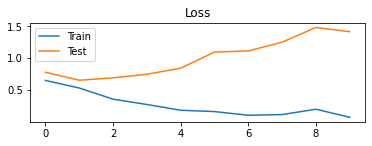

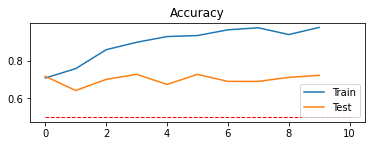

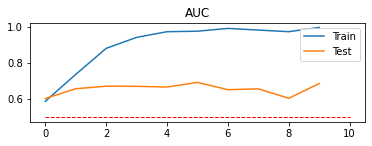

In [ ]:
#Plot loss during training
plt.subplot(212)
plt.title('Loss')
plt.plot(train_history.history['loss'], label='Train')
plt.plot(train_history.history['val_loss'], label='Test')
plt.legend()
plt.show()

# plot Accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(train_history.history['binary_accuracy'], label='Train')
plt.plot(train_history.history['val_binary_accuracy'], label='Test')
plt.hlines(0.5, 0, 10, linestyles='dashed', colors = 'red', linewidth=1)
plt.legend()
plt.show()

# plot AUC during training
plt.subplot(212)
plt.title('AUC')
plt.plot(train_history.history['auc'], label='Train')
plt.plot(train_history.history['val_auc'], label='Test')
plt.hlines(0.5, 0, 10, linestyles='dashed', colors = 'red', linewidth=1)
plt.legend()
plt.show()
